# Angler tests

In [2]:
import sys; sys.path.append("../..") # use local neural_maxwell package

import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

from tqdm import tqdm, tqdm_notebook

from angler import Simulation
from angler.derivatives import unpack_derivs

from neural_maxwell.datasets.generators1d import * 
from neural_maxwell.constants import *

np.set_printoptions(precision=3)

In [3]:
tqdm.format_sizeof(29991123)

'30.0M'

In [50]:
DEVICE_LENGTH = 64
CAVITY_BUFFER = 16
BUFFER_PERMITTIVITY = 1#-1e20
NPML = 16
DL = 0.05
# L0 = 1e-6
MODE = "Ez"

In [51]:
# OMEGA = 1.215e15
# MU0 = 4 * np.pi * 10**-7
# EPSILON0 =  8.854187817620e-12 
# SCALE = 1e-15
# C = 299792458.0
# L0 = 1e-6
# PIXEL_SIZE = DL * L0
# wavelength = 2 * np.pi * C / OMEGA

In [52]:
# total_length = DEVICE_LENGTH + 2 * CAVITY_BUFFER + 2 * NPML

# def get_curl_operator(l=total_length):

#     perms = np.ones(total_length, dtype=np.float64)

#     start = NPML + CAVITY_BUFFER
#     end = start + DEVICE_LENGTH

#     perms[:start] = BUFFER_PERMITTIVITY
#     perms[end:] = BUFFER_PERMITTIVITY

#     sim = Simulation(OMEGA, perms, DL, [NPML, 0], MODE, L0=L0)

#     Dyb, Dxb, Dxf, Dyf = unpack_derivs(sim.derivs)
    
#     N = np.asarray(perms.shape) 
#     M = np.prod(N) 
    
#     vector_eps_z = EPSILON0 * L0 * perms.reshape((-1,))
#     T_eps_z = sp.spdiags(vector_eps_z, 0, M, M, format='csr')
        
#     curl_curl = (Dxf@Dxb + Dyf@Dyb)
    
#     other = OMEGA**2 * MU0 * L0 * T_eps_z
    
#     return curl_curl.todense(), other.todense()

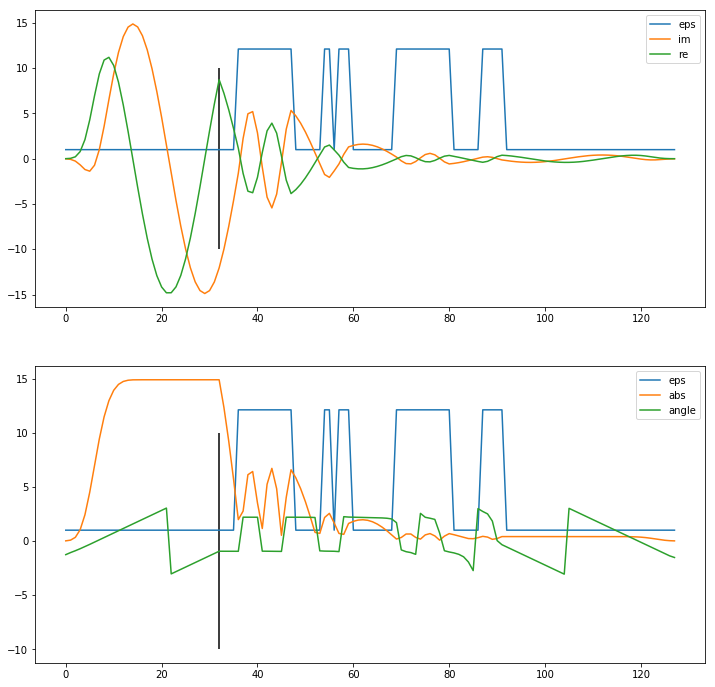

In [57]:
epsilons = perm_random_number_alternating_layers(s=DEVICE_LENGTH, eps1=1.0, eps2=eps_si)
# epsilons = np.ones(DEVICE_LENGTH)
# epsilons[150:] = 3

total_length = DEVICE_LENGTH + 2 * CAVITY_BUFFER + 2 * NPML
start = NPML + CAVITY_BUFFER
end = start + DEVICE_LENGTH

# need to use two rows to avoid issues with fd-derivative operators
# perms = np.ones((2, total_length), dtype=np.float64)
perms = np.ones(total_length, dtype=np.float64)


# set permittivity and reflection zone
# perms[:, :start] = BUFFER_PERMITTIVITY
# perms[:, start:end] = epsilons
# perms[:, end:] = BUFFER_PERMITTIVITY

perms[start-CAVITY_BUFFER:start] = BUFFER_PERMITTIVITY
perms[start:end] = epsilons
perms[end:end+CAVITY_BUFFER] = BUFFER_PERMITTIVITY

src_x = NPML + CAVITY_BUFFER # int(DEVICE_LENGTH / 2)

sim = Simulation(OMEGA, perms, DL, [NPML, 0], MODE, L0=L0)

# sim.src[:, src_x] = 1j
sim.src[src_x] = 1j

clip0 = NPML + CAVITY_BUFFER
clip1 = -(NPML + CAVITY_BUFFER)

Hx, Hy, Ez = sim.solve_fields()
# perms = perms[:, clip0:clip1]
# Hx = Hx[:, clip0:clip1]
# Hy = Hy[:, clip0:clip1]
# Ez = Ez[:, clip0:clip1]

fix, ax = plt.subplots(2,1, figsize = (12,12))
ax[0].plot(perms, label="eps")
ax[0].plot(np.imag(Ez), label="im")
ax[0].plot(np.real(Ez), label="re")
ax[0].vlines(src_x, -10,10)
# ax[0].set_ylim([-10,10])
ax[0].legend()

ax[1].plot(perms, label="eps")
ax[1].plot(np.abs(Ez), label="abs")
ax[1].plot(np.angle(Ez), label="angle")
ax[1].vlines(src_x, -10,10)
ax[1].legend()
# ax[1].set_ylim([-10,10])
plt.show()


# fix, ax = plt.subplots(2,1, figsize = (12,12))
# ax[0].plot(perms[0], label="eps")
# ax[0].plot(np.imag(Ez[0]), label="im")
# ax[0].plot(np.real(Ez[0]), label="re")
# ax[0].vlines(src_x, -10,10)
# ax[0].legend()

# ax[1].plot(perms[0], label="eps")
# ax[1].plot(np.abs(Ez[0]), label="abs")
# # ax[1].plot(np.angle(Ez[0])+DL*np.abs(np.arange(-total_length//2, total_length//2)), label="angle")
# ax[1].plot(np.angle(Ez[0]), label="angle")
# ax[1].legend()
# plt.show()

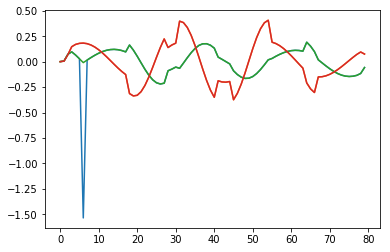

In [31]:
curl_op, eps_op = get_A_ops_1d(np.ones(perms.shape), NPML)
curl_op = np.asarray(curl_op)
E = Ez.flatten()

curl_curl_E = (SCALE / L0**2) * curl_op @ E
epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * perms * E

plt.plot(np.real(curl_curl_E))
plt.plot(np.imag(curl_curl_E))
plt.plot(np.real(epsilon_E))
plt.plot(np.imag(epsilon_E))

plt.show()

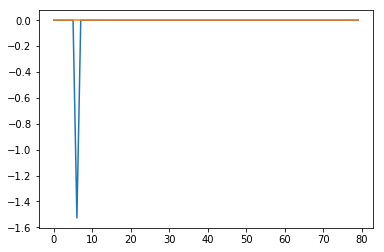

In [32]:
zero = curl_curl_E-epsilon_E
plt.plot(np.real(zero))
plt.plot(np.imag(zero))
plt.show()

In [35]:
(curl_curl_E+epsilon_E)[16+32]

-1.5268139564659675

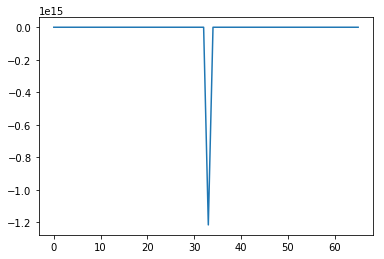

In [23]:
A = sim.A.todense()
curl=np.real(np.asarray(A[15:-15,15:-15] @ np.real(Ez)[15:-15].flatten()))[0]
plt.plot(curl)
plt.show()

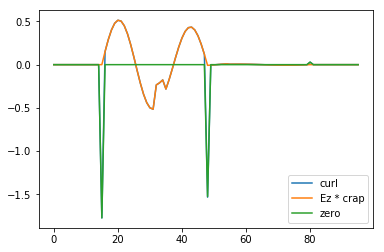

In [22]:
# plt.plot(perms[15:-15], label="eps")

curl_curl, other = get_curl_operator()

# fields = np.array([np.zeros(16), np.real(Ez)[16:-16], np.zeros(16)]).flatten()
fields = np.pad(np.real(Ez).flatten()[16:-16], (16,16), 'constant')

# curl=np.real(np.asarray(curl_curl[15:-15,15:-15] @ np.real(Ez)[15:-15].flatten()))[0]
curl=np.real(SCALE / (L0**2) * np.asarray(curl_curl @ fields))[0]
plt.plot(curl, label="curl")

# o2 = perms[15:-15] * np.real(np.asarray(other[15:-15,15:-15] @ np.real(Ez)[15:-15].flatten()))[0]
# o2 = perms * np.real(np.asarray(other @ fields))[0]
o2 = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * perms * fields

src = np.zeros(fields.shape)
src[32] = SCALE * OMEGA

plt.plot(o2, label='Ez * crap')
# plt.ylim([-200,200])

zero = curl - o2
plt.plot(zero, label='zero')

# plt.plot(fields, label='fields')
plt.legend()
plt.show()

In [23]:
Ez.shape

(96, 1)

In [25]:
zero[16]

4.190374297552424e-09

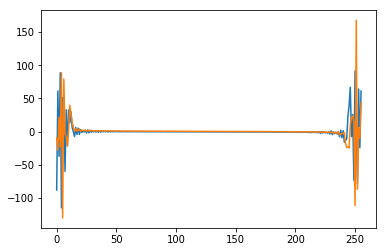

In [16]:
fft = np.fft.fft(Ez[0][32:-32])
plt.plot(np.real(fft))
plt.plot(np.imag(fft))
# plt.plot(np.fft.ifft(fft))
# plt.plot(perms[0], label="eps")

plt.show()

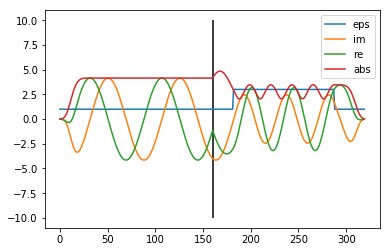

In [110]:
plt.plot(perms[0], label="eps")
plt.plot(np.imag(Ez[0]), label="im")
plt.plot(np.real(Ez[0]), label="re")
plt.vlines(src_x, -10,10)
plt.plot(np.abs(Ez[0]), label="abs")
# plt.plot(np.angle(Ez[0]), label="angle")
plt.legend()
plt.show()

In [63]:
from angler import Simulation
import numpy as np
import scipy

omega = 2*np.pi*2e14
eps_r = np.ones((8,1))
eps_r[:2] = -1e19
eps_r[-2:] = -1e19
S = Simulation(omega, eps_r, 0.01, [0, 0], 'Ez')
A = S.A.todense()
null = scipy.linalg.null_space(A).T

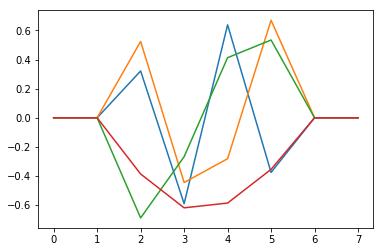

In [64]:
freqs = [np.fft.fft(n[2:-2]) for n in null]
# [plt.plot(np.real(freq)) for freq in freqs]
[plt.plot(np.real(n)) for n in null]
plt.show()

(200,)